In [ ]:
!git clone https://github.com/rhisehl/Customer-Churn-Model

Cloning into 'Customer-Churn-Model'...
remote: Enumerating objects: 497, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 497 (delta 5), reused 11 (delta 3), pack-reused 481
Receiving objects: 100% (497/497), 11.86 MiB | 1.19 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pydotplus
import os
from IPython.display import Image
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import *   # scalers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Set up S3 import
!pip install boto3
import boto3

BUCKET_NAME = 'ecommerce-machine-learning-resources-5.29.23'

from config import aws_access_key_id, aws_secret_access_key, region

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.7 MB/s eta 0:00:00


In [ ]:
# Authentication credentials for S3
s3 = boto3.resource('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key)
KEY = 'cleaned_data.csv'
# Import file
s3.Bucket(BUCKET_NAME).download_file(KEY,'cleaned_data.csv')

In [ ]:
# Read CSV into DataFrame
df = pd.read_csv('cleaned_data.csv',index_col=0)
df.set_index("CustomerID",inplace=True)
df

,Churn,Tenure,PreferredLoginDevice,PreferredPaymentMode,Gender,AppHours,RegisteredDevices,PreferredCategory,SatisfactionScore,MaritalStatus,...,Complaint,OrderIncreasePercent,CouponsUsed,OrderCount,DaysSinceOrder,AverageCashback,Age,Race,HouseholdIncome,PersonalIncome
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,1,4.0,Mobile Phone,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,...,1,11.0,1.0,1.0,5.0,160,80,White,53704.40,53704.40
50004,1,0.0,Mobile Phone,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,...,0,23.0,0.0,1.0,3.0,134,20,Other,99863.00,6798.03
50006,1,0.0,Computer,Debit Card,Female,3.0,5,Mobile Phone,5,Single,...,1,22.0,4.0,6.0,7.0,139,60,White,50985.19,50985.19
50012,1,11.0,Mobile Phone,Debit Card,Male,3.0,4,Fashion,3,Single,...,1,13.0,0.0,1.0,0.0,154,29,Black,53024.60,16995.06
50013,1,0.0,Mobile Phone,Cash on Delivery,Male,2.0,3,Mobile,3,Single,...,1,13.0,2.0,2.0,2.0,134,39,White,18184.72,18184.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55625,0,1.0,Mobile Phone,Unified Payment Interface,Female,2.0,5,Mobile Phone,3,Single,...,0,19.0,2.0,2.0,1.0,155,24,White,191194.47,63731.49
55626,0,10.0,Computer,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,...,0,18.0,1.0,2.0,4.0,151,36,White,103160.04,101970.38
55628,0,1.0,Mobile Phone,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,...,1,21.0,1.0,2.0,4.0,186,63,White,95172.36,64581.24


In [ ]:
clean_df = df

# convert categorical data to numeric with `pd.get_dummies`
df2 = clean_df.copy()
df = pd.get_dummies(df2)
df

,Churn,Tenure,AppHours,RegisteredDevices,SatisfactionScore,NumberAddresses,Complaint,OrderIncreasePercent,CouponsUsed,OrderCount,...,MaritalStatus_Married,MaritalStatus_Single,Race_American Indian or Alaska Native,Race_Black,Race_Chinese,Race_Japanese,Race_Other,Race_Other Asian or Pacific Islander,Race_Two major races,Race_White
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,1,4.0,3.0,3,2,9,1,11.0,1.0,1.0,...,0,1,0,0,0,0,0,0,0,1
50004,1,0.0,2.0,4,5,8,0,23.0,0.0,1.0,...,0,1,0,0,0,0,1,0,0,0
50006,1,0.0,3.0,5,5,2,1,22.0,4.0,6.0,...,0,1,0,0,0,0,0,0,0,1
50012,1,11.0,3.0,4,3,10,1,13.0,0.0,1.0,...,0,1,0,1,0,0,0,0,0,0
50013,1,0.0,2.0,3,3,2,1,13.0,2.0,2.0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55625,0,1.0,2.0,5,3,2,0,19.0,2.0,2.0,...,0,1,0,0,0,0,0,0,0,1
55626,0,10.0,3.0,2,1,6,0,18.0,1.0,2.0,...,1,0,0,0,0,0,0,0,0,1
55628,0,1.0,3.0,2,4,3,1,21.0,1.0,2.0,...,1,0,0,0,0,0,0,0,0,1


# Train, Validation, Test Datasets

In [ ]:
# Create variables
churn =['Active', 'Inactive']
oversamples = [ 'False', 'True']
scalers=[StandardScaler(),MinMaxScaler(),PowerTransformer(method='yeo-johnson'),RobustScaler(quantile_range=(25, 75)),MaxAbsScaler()]

##  kNN variables
neighbor_nums = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [ ]:
# Reset dataset to begin with original data again
def start_dataset():

  # Separate the data into labels and features
    # the y variable, the labels (0 = Active Customer, 1 = Inactive Customer)
  y = df['Churn']
    # the X variable, the features
  X = df.drop(columns='Churn')

  # Split into testing and training sets using train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
  X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, random_state=1)

  # recombobulate datasets
  train = X_train.join(y_train)
  valid = X_valid.join(y_valid)
  test = X_test.join(y_test)

  return X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y

In [ ]:
# Scale (normalize) the dataset to avoid skewing caused by numbers of various sizes

def scale_dataset(train, oversample=False, scaler=StandardScaler()):
    y = df['Churn'].values
    X = df.drop(columns='Churn').values

    # Instantiate a StandardScaler instance
    scaler = scaler

    # fit the data and transform
    X = scaler.fit_transform(X)
    
    # if we decide to use the RandomOverSampler module due to a large variance in record numbers
    ## to take more of a less class and increase the size of the dataset
    if oversample:
        ros = RandomOverSampler(sampling_strategy='minority')
        X, y = ros.fit_resample(X, y)
        
    # create one huge 2d numpy array (hstack, horizontal stack side by side)
    train = np.hstack((X, np.reshape(y, (-1,1))))
    
    # return fit and transformed data
    return train, X, y

In [ ]:
# Generate confusion matrix and classification report information for print report and csv file processing
def confusion_classification(y_test, y_pred):

    # generate a confusion matrix for the model
    cm_df_init = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(
            cm_df_init, index=['Actual Active Customer', 'Actual Inactive Customer'],
            columns=['Predicted Active Customer', 'Predicted Inactive Customer']
    )
    
    # generate classification report dataframe details
    classification_df = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, target_names=churn, output_dict=True)).transpose()

    return(cm_df, classification_df)   

In [ ]:
# Begin processing
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

In [ ]:
# Verify all rows accounted for
df.shape[0], train.shape[0] + valid.shape[0] + test.shape[0]

(4019, 4019)

# Compile, Train and Evaluate the Machine Learning Models

#   Create a K-Nearest Neighbors (kNN) Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

run_model = 'K-Nearest Neighbors (kNN)'
# do for each in lists declared in the beginning
#  use kNN declared list variables
for neighbor_num in neighbor_nums:
    for oversample in oversamples:        
        for scaler in scalers:
          # scale (normalize) the datasets
          train, X_train, y_train = scale_dataset(train, oversample=oversample, scaler=scaler)
          valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
          test, X_test, y_test = scale_dataset(test, oversample=False)
          
          # fit the model using the original then the resampled training data   
            # using a pre-specified number of neighborhood points to classify a given point
          knn_model = KNeighborsClassifier(n_neighbors=neighbor_num)
          knn_model.fit(X_train, y_train)

          # make a prediction using the testing data
          y_pred = knn_model.predict(X_test)
          
         # generate a confusion matrix and classification data for the csv for the model
          cm_df, classification_df = confusion_classification(y_test, y_pred)
          
          # print the classification reports
          print(('*' * 50)+'\n')  
          print(f'{run_model} Model Reports')
          print(f'Parameters: {neighbor_num} n_neighbors, oversample={oversample}, scaler={scaler}\n')
          # print('Confusion Matrix')
          # display(cm_df)
          print('Classification Report')
          print(classification_report(y_test, y_pred, target_names=churn))

          # generate csv file of the model's scores
          classification_df.insert(0, 'Model', f'{run_model}')
          classification_df.insert(1, 'Oversample', f'{oversample}')
          classification_df.insert(2, 'Scaler', f'{scaler}')
          classification_df.insert(3, 'Neighbors', f'{neighbor_num}')
    
          classification_df.to_csv(f'Customer-Churn-Model/Results/{run_model}_Model_{oversample}_{scaler}_{neighbor_num}.csv',index=True)          

**************************************************

K-Nearest Neighbors (kNN) Model Reports
Parameters: 3 n_neighbors, oversample=False, scaler=StandardScaler()

Classification Report
              precision    recall  f1-score   support

      Active       1.00      0.93      0.96      3304
    Inactive       0.76      0.99      0.86       715

    accuracy                           0.94      4019
   macro avg       0.88      0.96      0.91      4019
weighted avg       0.96      0.94      0.95      4019

**************************************************

K-Nearest Neighbors (kNN) Model Reports
Parameters: 3 n_neighbors, oversample=False, scaler=MinMaxScaler()

Classification Report
              precision    recall  f1-score   support

      Active       1.00      0.93      0.96      3304
    Inactive       0.74      0.98      0.85       715

    accuracy                           0.94      4019
   macro avg       0.87      0.96      0.90      4019
weighted avg       0.95      0.94  

In [ ]:
# no more neighbors
neighbor_num = 0

# Create Naive Bayes Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()
classification_df = []
neighbor_num = 0

run_model = 'Naive Bayes'
# do for each in lists declared in the beginning
for oversample in oversamples:
    for scaler in scalers:
      # scale (normalize) the train and test datasets            
      train, X_train, y_train = scale_dataset(train, oversample=oversample)
      valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
      test, X_test, y_test = scale_dataset(test, oversample=False)
      
      # fit the model using the original then the resampled training data
      nb_model = GaussianNB()
      nb_model = nb_model.fit(X_train, y_train)
      
      # make a prediction using the testing data
      y_pred = nb_model.predict(X_test)
     
      # generate a confusion matrix and classification data for the csv for the model
      cm_df, classification_df = confusion_classification(y_test, y_pred)
      
      # print the classification reports
      print(('*' * 50)+'\n')  
      print(f'{run_model} Model Reports')
      print(f'Parameters: oversample={oversample} and scaler={scaler}\n')
      # print('Confusion Matrix')
      # display(cm_df)
      print(f'Classification Report')
      print(classification_report(y_test, y_pred, target_names=churn))

      # generate csv file of the model's scores
      classification_df.insert(0, 'Model', f'{run_model}')
      classification_df.insert(1, 'Oversample', f'{oversample}')
      classification_df.insert(2, 'Scaler', f'{scaler}')
      classification_df.insert(3, 'Neighbors', f'{neighbor_num}')

      classification_df.to_csv(f'Customer-Churn-Model/Results/{run_model}_Model_{oversample}_{scaler}_{neighbor_num}.csv',index=True)          

**************************************************

Naive Bayes Model Reports
Parameters: oversample=False and scaler=StandardScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.93      0.71      0.81      3304
    Inactive       0.36      0.75      0.49       715

    accuracy                           0.72      4019
   macro avg       0.65      0.73      0.65      4019
weighted avg       0.83      0.72      0.75      4019

**************************************************

Naive Bayes Model Reports
Parameters: oversample=False and scaler=MinMaxScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.93      0.68      0.78      3304
    Inactive       0.34      0.77      0.47       715

    accuracy                           0.69      4019
   macro avg       0.64      0.72      0.63      4019
weighted avg       0.83      0.69      0.73      4019

********************************

# Create Logistic Regression Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()
classification_df = []
neighbor_num = 0

run_model = 'Logistic Regression'
# Fit the model using the original then the resampled training data,
for oversample in oversamples:
  for scaler in scalers:     
    # scale (normalize) the train and test datasets     
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
      
    # Fit the model using the original then the resampled training data
    lg_model = LogisticRegression()
    lg_model = lg_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = lg_model.predict(X_test)
         
    # generate a confusion matrix and classification data for the csv for the model
    cm_df, classification_df = confusion_classification(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print(f'{run_model} Model Reports')
    print(f'Parameters: oversample={oversample} and scaler={scaler}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn))

    # generate csv file of the model's scores
    classification_df.insert(0, 'Model', f'{run_model}')
    classification_df.insert(1, 'Oversample', f'{oversample}')
    classification_df.insert(2, 'Scaler', f'{scaler}')
    classification_df.insert(3, 'Neighbors', f'{neighbor_num}')

    classification_df.to_csv(f'Customer-Churn-Model/Results/{run_model}_Model_{oversample}_{scaler}_{neighbor_num}.csv',index=True)          

**************************************************

Logistic Regression Model Reports
Parameters: oversample=False and scaler=StandardScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.95      0.79      0.86      3304
    Inactive       0.46      0.80      0.58       715

    accuracy                           0.79      4019
   macro avg       0.70      0.80      0.72      4019
weighted avg       0.86      0.79      0.81      4019

**************************************************

Logistic Regression Model Reports
Parameters: oversample=False and scaler=MinMaxScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.95      0.79      0.86      3304
    Inactive       0.45      0.81      0.58       715

    accuracy                           0.79      4019
   macro avg       0.70      0.80      0.72      4019
weighted avg       0.86      0.79      0.81      4019

****************

# Create Support Vector Machines (SVM) Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()
classification_df = []
neighbor_num = 0

run_model = 'Support Vector Machines (SVM)'
# Fit the model using the original then the resampled training data,
for oversample in oversamples:
  for scaler in scalers:     
    # scale (normalize) the train and test datasets     
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
     
    # Fit the model using the original then the resampled training data
    svm_model = SVC()
    svm_model = svm_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = svm_model.predict(X_test)
    
    # generate a confusion matrix and classification data for the csv for the model
    cm_df, classification_df = confusion_classification(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print(f'{run_model} Model Reports')
    print(f'Parameters: oversample={oversample} and scaler={scaler}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn)) 

    # generate csv file of the model's scores
    classification_df.insert(0, 'Model', f'{run_model}')
    classification_df.insert(1, 'Oversample', f'{oversample}')
    classification_df.insert(2, 'Scaler', f'{scaler}')
    classification_df.insert(3, 'Neighbors', f'{neighbor_num}')

    classification_df.to_csv(f'Customer-Churn-Model/Results/{run_model}_Model_{oversample}_{scaler}_{neighbor_num}.csv',index=True)          

**************************************************

Support Vector Machines (SVM) Model Reports
Parameters: oversample=False and scaler=StandardScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.99      0.92      0.95      3304
    Inactive       0.72      0.97      0.82       715

    accuracy                           0.93      4019
   macro avg       0.86      0.94      0.89      4019
weighted avg       0.94      0.93      0.93      4019

**************************************************

Support Vector Machines (SVM) Model Reports
Parameters: oversample=False and scaler=MinMaxScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.99      0.92      0.96      3304
    Inactive       0.73      0.96      0.83       715

    accuracy                           0.93      4019
   macro avg       0.86      0.94      0.89      4019
weighted avg       0.94      0.93      0.93      40

# Create Decision Tree Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()
classification_df = []
neighbor_num = 0

run_model = 'Decision Tree'
# Fit the model using the original then the resampled training data,
for oversample in oversamples:
  for scaler in scalers:     
    # scale (normalize) the train and test datasets     
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
     
    # Fit the model using the original then the resampled training data
    tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth = 5)
    tree_model = tree_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = tree_model.predict(X_test)
    
    # generate a confusion matrix and classification data for the csv for the model
    cm_df, classification_df = confusion_classification(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print(f'{run_model} Model Reports')
    print(f'Parameters: oversample={oversample} and scaler={scaler}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn)) 
    
    # generate csv file of the model's scores
    classification_df.insert(0, 'Model', f'{run_model}')
    classification_df.insert(1, 'Oversample', f'{oversample}')
    classification_df.insert(2, 'Scaler', f'{scaler}')
    classification_df.insert(3, 'Neighbors', f'{neighbor_num}')

    classification_df.to_csv(f'Customer-Churn-Model/Results/{run_model}_Model_{oversample}_{scaler}_{neighbor_num}.csv',index=True)          

**************************************************

Decision Tree Model Reports
Parameters: oversample=False and scaler=StandardScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.94      0.89      0.91      3304
    Inactive       0.59      0.75      0.66       715

    accuracy                           0.86      4019
   macro avg       0.77      0.82      0.79      4019
weighted avg       0.88      0.86      0.87      4019

**************************************************

Decision Tree Model Reports
Parameters: oversample=False and scaler=MinMaxScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.95      0.85      0.90      3304
    Inactive       0.53      0.80      0.64       715

    accuracy                           0.84      4019
   macro avg       0.74      0.82      0.77      4019
weighted avg       0.88      0.84      0.85      4019

****************************

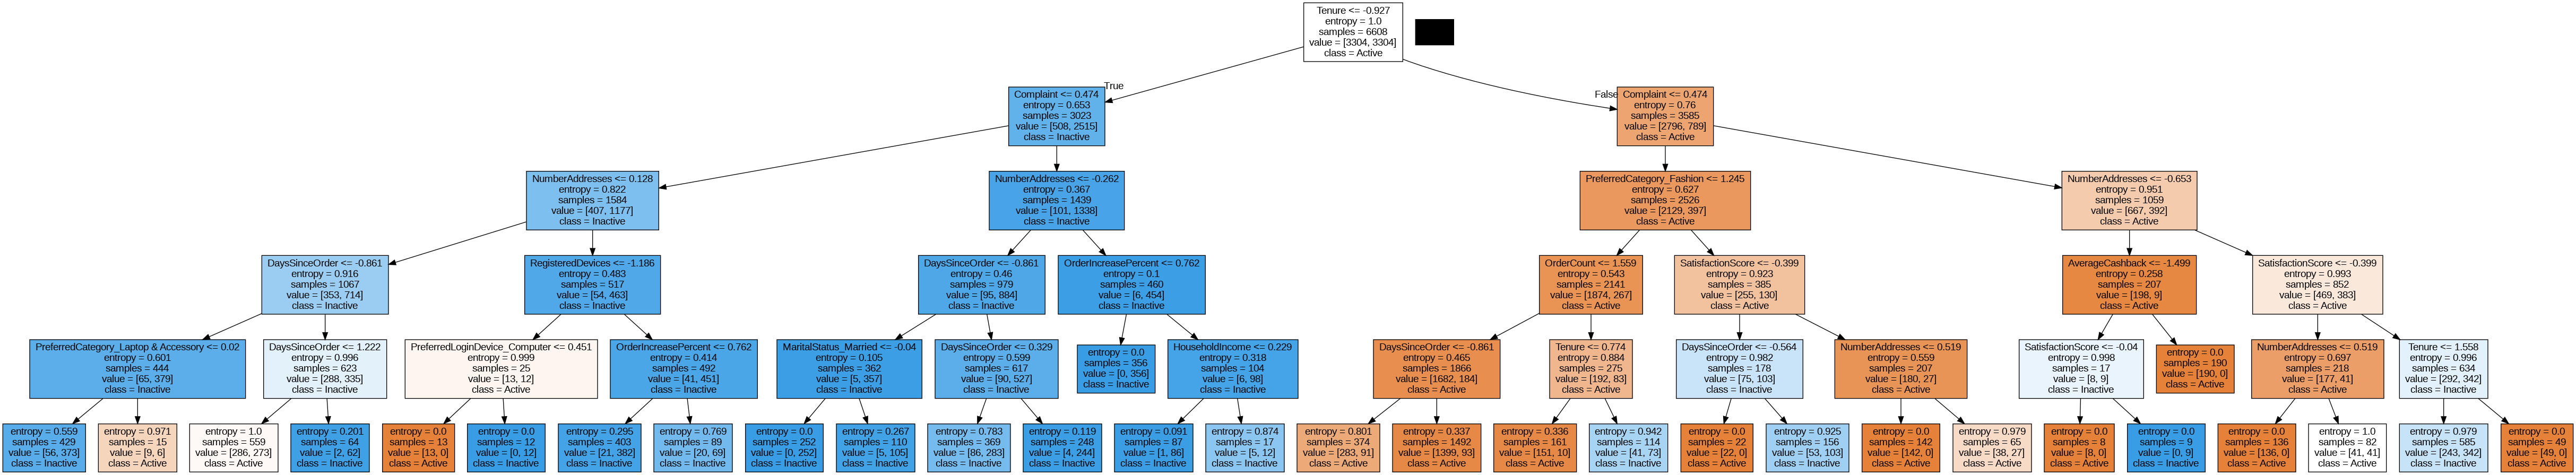

In [ ]:
# Visualize the Decision Tree
filepath_tree_graph = 'Customer-Churn-Model/Results/Ecommerce_Decision_Tree_Graph.png'

  # create DOT data
dot_data = tree.export_graphviz(
    tree_model, out_file=None, feature_names=X.columns, class_names=churn, filled=True
)

  # draw graph
tree_graph = pydotplus.graph_from_dot_data(dot_data)
  # show graph
Image(tree_graph.create_png())

In [ ]:
# Save the Decision Tree

file_path = (filepath_tree_graph)
tree_graph.write_png(file_path)

True

# Create Random Forests Model with Reports

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()
classification_df = []
neighbor_num = 0

run_model = 'Random Forests'
# Fit the model using the original then the resampled training data,
for oversample in oversamples:
  for scaler in scalers:     
    # scale (normalize) the train and test datasets     
    train, X_train, y_train = scale_dataset(train, oversample=oversample)
    valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
    test, X_test, y_test = scale_dataset(test, oversample=False)
     
    # Fit the model using the original then the resampled training data
    rf_model = RandomForestClassifier(random_state=42, n_estimators=3, max_depth=4)
    rf_model = rf_model.fit(X_train, y_train)
    
    # make a prediction using the testing data
    y_pred = rf_model.predict(X_test)
    
    # generate a confusion matrix and classification data for the csv for the model
    cm_df, classification_df = confusion_classification(y_test, y_pred)

    # print the classification reports
    print(('*' * 50)+'\n')  
    print(f'{run_model} Model Reports')
    print(f'Parameters: oversample={oversample} and scaler={scaler}\n')
    # print('Confusion Matrix')
    # display(cm_df)
    print(f'Classification Report')
    print(classification_report(y_test, y_pred, target_names=churn)) 
    
    # generate csv file of the model's scores
    classification_df.insert(0, 'Model', f'{run_model}')
    classification_df.insert(1, 'Oversample', f'{oversample}')
    classification_df.insert(2, 'Scaler', f'{scaler}')
    classification_df.insert(3, 'Neighbors', f'{neighbor_num}')

    classification_df.to_csv(f'Customer-Churn-Model/Results/{run_model}_Model_{oversample}_{scaler}_{neighbor_num}.csv',index=True)          

**************************************************

Random Forests Model Reports
Parameters: oversample=False and scaler=StandardScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.95      0.85      0.90      3304
    Inactive       0.53      0.81      0.64       715

    accuracy                           0.84      4019
   macro avg       0.74      0.83      0.77      4019
weighted avg       0.88      0.84      0.85      4019

**************************************************

Random Forests Model Reports
Parameters: oversample=False and scaler=MinMaxScaler()

Classification Report
              precision    recall  f1-score   support

      Active       0.95      0.82      0.88      3304
    Inactive       0.49      0.81      0.61       715

    accuracy                           0.82      4019
   macro avg       0.72      0.81      0.75      4019
weighted avg       0.87      0.82      0.83      4019

**************************

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

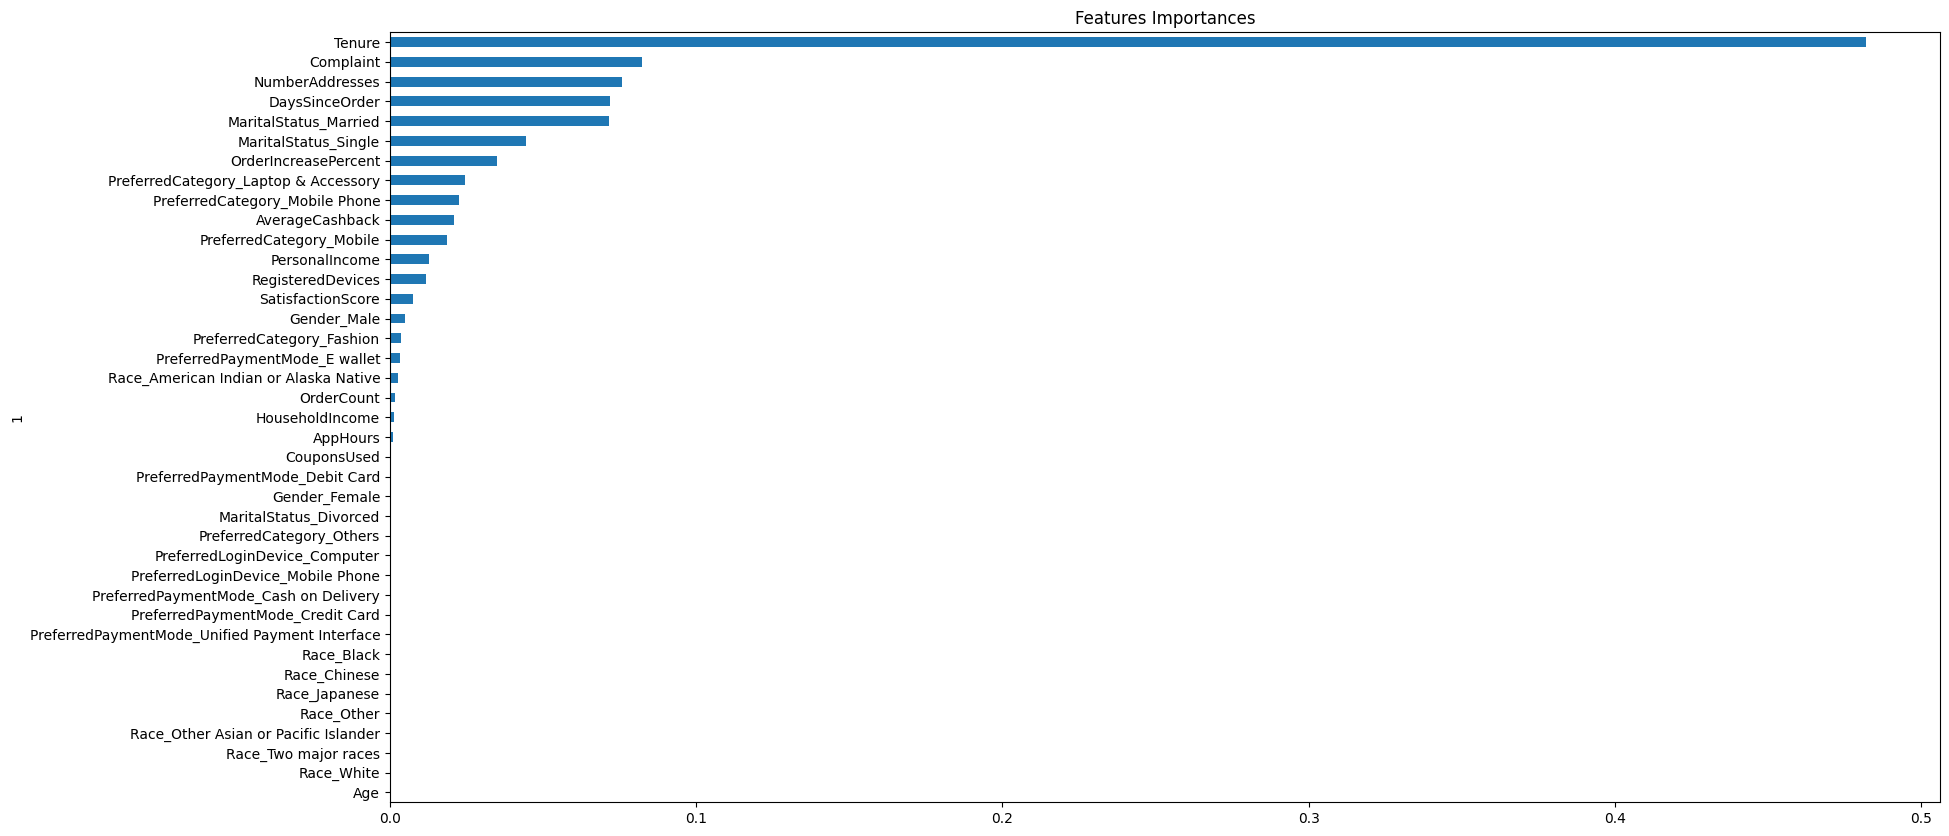

In [ ]:
# Calculate feature importance
importances = rf_model.feature_importances_
# Sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', title= 'Features Importances', legend=False, figsize=(20,10))

[Text(0.5, 0.9, 'MaritalStatus_Single <= 0.474\ngini = 0.5\nsamples = 4168\nvalue = [3283, 3325]\nclass = Inactive'),
 Text(0.25, 0.7, 'Race_Other <= 0.02\ngini = 0.469\nsamples = 2535\nvalue = [2515, 1512]\nclass = Active'),
 Text(0.125, 0.5, 'Tenure <= -0.927\ngini = 0.498\nsamples = 1442\nvalue = [1235, 1101]\nclass = Active'),
 Text(0.0625, 0.3, 'NumberAddresses <= -2.16\ngini = 0.339\nsamples = 687\nvalue = [236, 857]\nclass = Inactive'),
 Text(0.03125, 0.1, 'gini = 0.389\nsamples = 21\nvalue = [25, 9]\nclass = Active'),
 Text(0.09375, 0.1, 'gini = 0.319\nsamples = 666\nvalue = [211, 848]\nclass = Inactive'),
 Text(0.1875, 0.3, 'OrderIncreasePercent <= 2.138\ngini = 0.316\nsamples = 755\nvalue = [999, 244]\nclass = Active'),
 Text(0.15625, 0.1, 'gini = 0.298\nsamples = 726\nvalue = [976, 217]\nclass = Active'),
 Text(0.21875, 0.1, 'gini = 0.497\nsamples = 29\nvalue = [23, 27]\nclass = Inactive'),
 Text(0.375, 0.5, 'PreferredPaymentMode_Debit Card <= -0.04\ngini = 0.368\nsamples = 

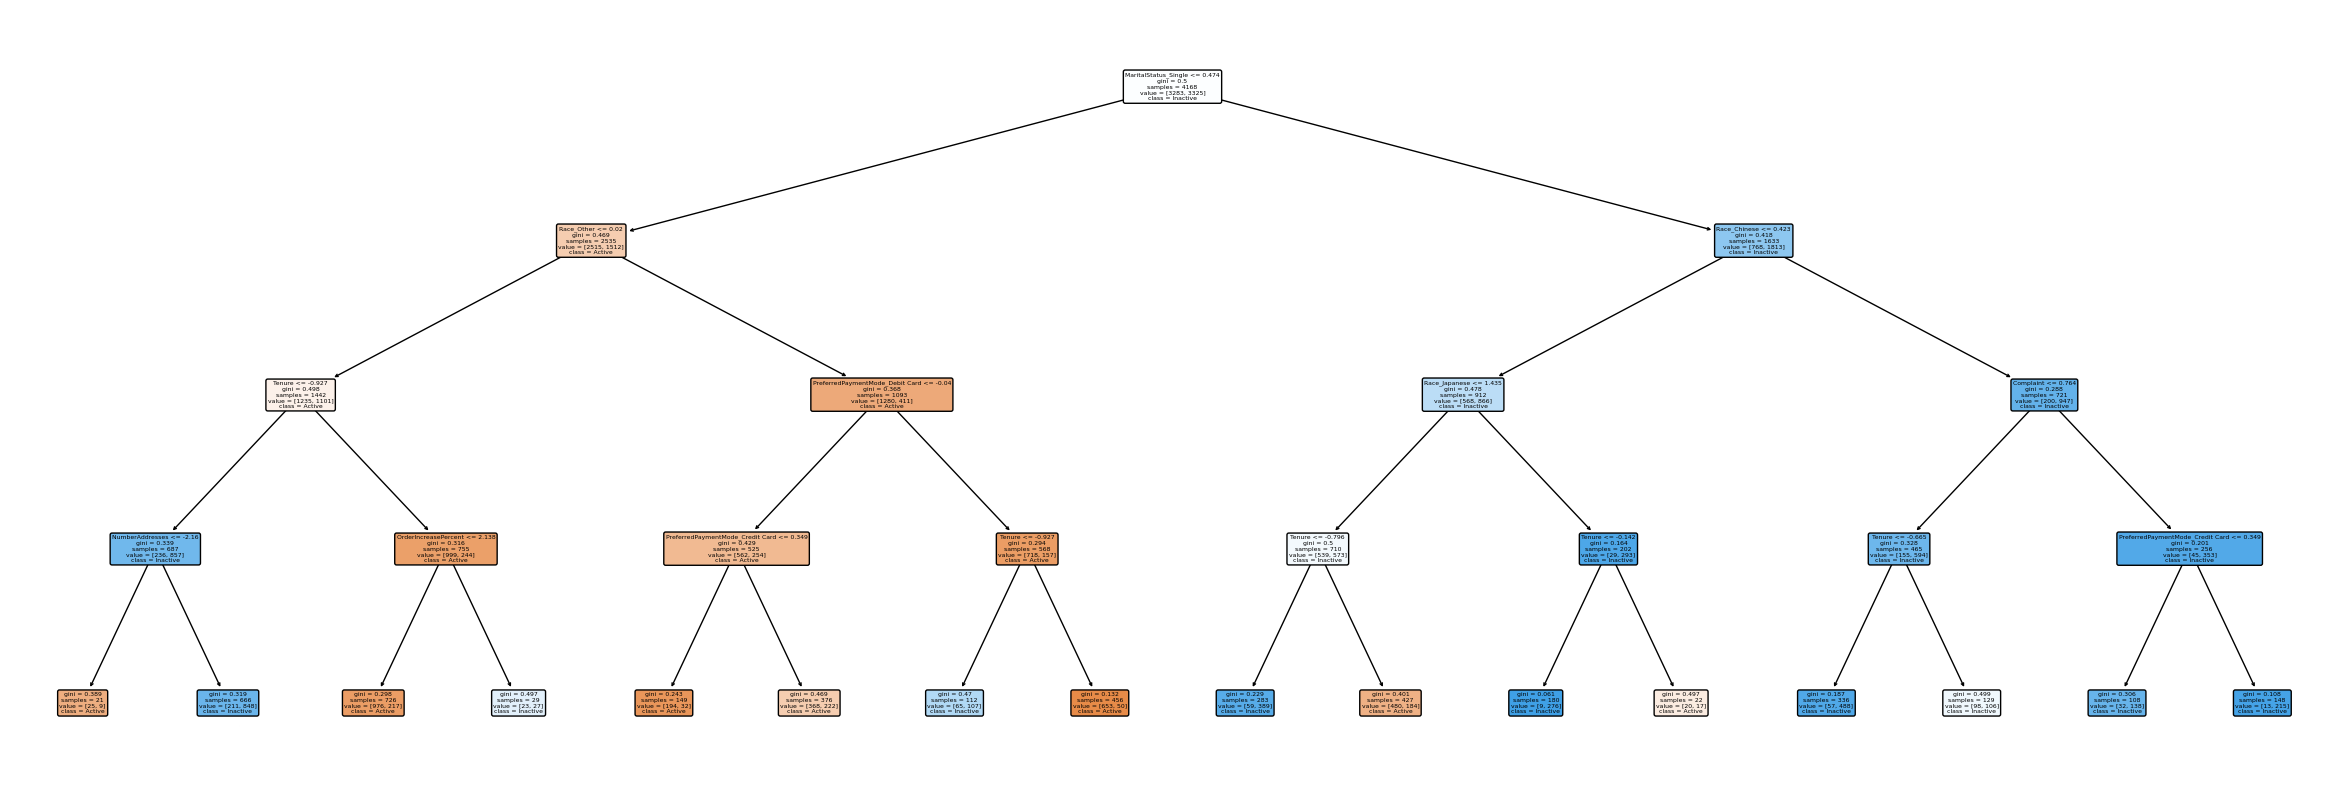

In [ ]:
# plot the entire forest
features = importances_df.index

fig = plt.figure(figsize=(30, 10))

plot_tree(rf_model.estimators_[0], 
          feature_names=features,
          class_names=churn, 
          filled=True, impurity=True, 
          rounded=True)

[Text(0.5, 0.875, 'MaritalStatus_Single <= 0.474\ngini = 0.5\nsamples = 4168\nvalue = [3283, 3325]\nclass = Inactive'),
 Text(0.25, 0.625, 'Race_Other <= 0.02\ngini = 0.469\nsamples = 2535\nvalue = [2515, 1512]\nclass = Active'),
 Text(0.125, 0.375, 'Tenure <= -0.927\ngini = 0.498\nsamples = 1442\nvalue = [1235, 1101]\nclass = Active'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'PreferredPaymentMode_Debit Card <= -0.04\ngini = 0.368\nsamples = 1093\nvalue = [1280, 411]\nclass = Active'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'Race_Chinese <= 0.423\ngini = 0.418\nsamples = 1633\nvalue = [768, 1813]\nclass = Inactive'),
 Text(0.625, 0.375, 'Race_Japanese <= 1.435\ngini = 0.478\nsamples = 912\nvalue = [568, 866]\nclass = Inactive'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'Complaint <= 0.764\ngini = 0.288\nsamples = 72

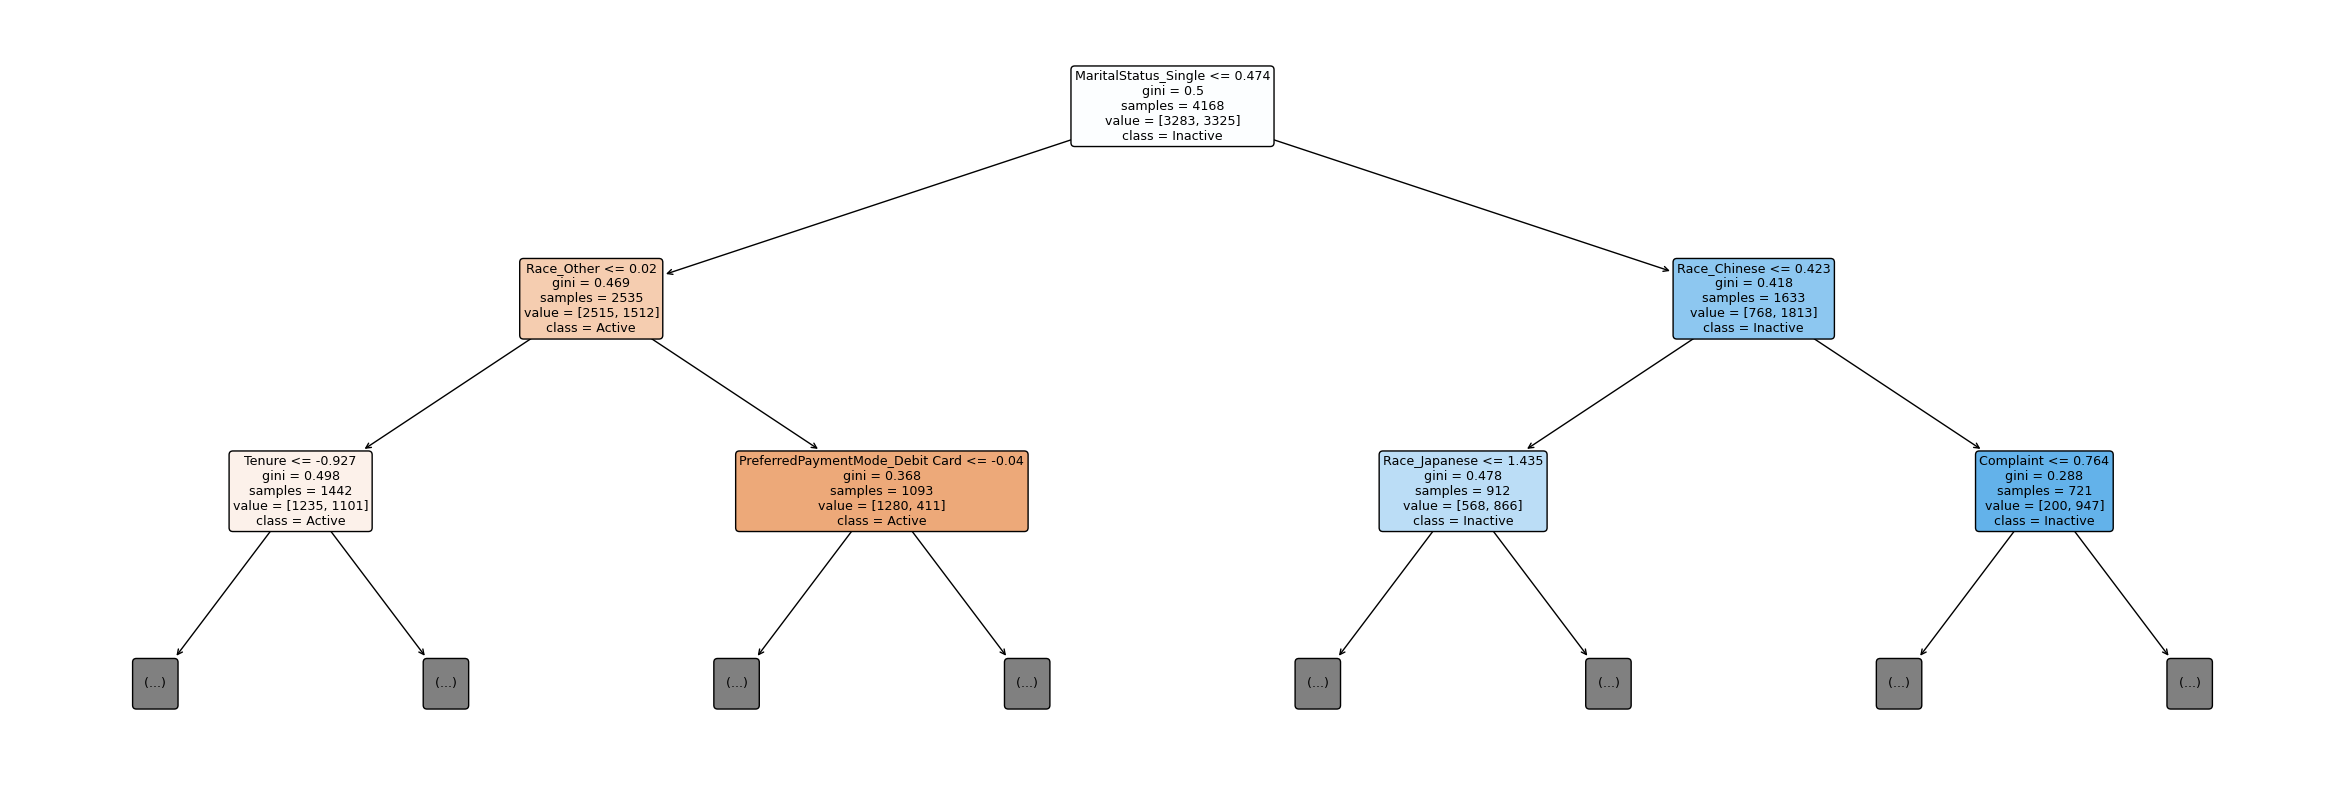

In [ ]:
# plot a small branch from the forest

fig = plt.figure(figsize=(30, 10))
plot_tree(rf_model.estimators_[0], 
          max_depth=2,
          feature_names=features,
          class_names=churn, 
          filled=True, impurity=True, 
          rounded=True)

# Create one csv file for all models' scores

In [ ]:
# Iterate over the csv files in the Results directory

# directory where csv files are stored
root = 'Customer-Churn-Model/Results/'

# iterate over csv files in directory, add to list
path_list = []
for csv_file in os.listdir(root):
  if csv_file.endswith('.csv'):
    path = f'{root}/{csv_file}'
    path_list.append(path)

# read csv files from list
merged_model_df = pd.concat(map(pd.read_csv, path_list))

# define output path for the newly merged file data
output_path = os.path.join(root, 'final_model_data.csv')

# save the merged data to a single csv file
merged_model_df.to_csv(output_path, index=True)

In [ ]:
# Create zip file to download for push to GitHub
!zip -r /content/Results.zip /content/Customer-Churn-Model/Results

updating: content/Customer-Churn-Model/Results/ (stored 0%)
updating: content/Customer-Churn-Model/Results/K-Nearest Neighbors (kNN)_Model_False_RobustScaler(quantile_range=(25, 75))_9.csv (deflated 61%)
updating: content/Customer-Churn-Model/Results/Logistic Regression_Model_True_MinMaxScaler()_0.csv (deflated 55%)
updating: content/Customer-Churn-Model/Results/Support Vector Machines (SVM)_Model_True_PowerTransformer()_0.csv (deflated 58%)
updating: content/Customer-Churn-Model/Results/K-Nearest Neighbors (kNN)_Model_True_StandardScaler()_15.csv (deflated 58%)
updating: content/Customer-Churn-Model/Results/K-Nearest Neighbors (kNN)_Model_True_MaxAbsScaler()_22.csv (deflated 58%)
updating: content/Customer-Churn-Model/Results/K-Nearest Neighbors (kNN)_Model_True_StandardScaler()_19.csv (deflated 58%)
updating: content/Customer-Churn-Model/Results/K-Nearest Neighbors (kNN)_Model_True_MinMaxScaler()_19.csv (deflated 59%)
updating: content/Customer-Churn-Model/Results/Support Vector Mach

# Not Used in Final Analyses:

## Create Neural Networks Model with Reports

In [ ]:
# Functions to plot the loss and accuracy for Neural Network Modeling
def plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, oversample, batch_size, epochs, save_graph ):
    filepath_plot = 'Customer-Churn-Model/Results/Neural_Network_Loss_Accuracy_Graph.png'
    # plot variables
    acc = f'{a_score:.3%}'
    los = f'{l_score}'
    s_title = f'Model: StandardScaler with {number_input_features} Features, Accuracy: {acc}'
    n_title = f'Nodes: {node}, dropout: {dropout_probability}, lr: {learning_rate}, ros: {oversample}, epochs: {epochs}, batch_size: {batch_size}, Loss: {los}'

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentrophy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    # ax2.set_ylabel('  ')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle(s_title, ha='right')
    plt.title(n_title, ha='right')

    if save_graph == True:
      plt.savefig(filepath_plot)

    plt.show()

In [ ]:
def train_model(X_train, y_train, nodes, dropout_probability, learning_rate, oversample, batch_size, epochs):
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
  nn = tf.keras.models.Sequential([
  # First hidden layer
      tf.keras.layers.Dense(nodes, input_dim=number_input_features, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Second hidden layer
      tf.keras.layers.Dense(nodes, activation="relu"),
      tf.keras.layers.Dropout(dropout_probability),
  # Output layer
      tf.keras.layers.Dense(1, activation="sigmoid")
  ])
  # Check the structure of the model
  nn.summary()

  # Compile the model
  nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

  # Train the model
  history = nn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=0)

  return nn, history

In [ ]:
# Reset dataset
X_train, X_valid, X_test, y_train, y_valid, y_test, train, valid, test, X, y = start_dataset()

# scale (normalize) the train and test datasets     
oversample=False
train, X_train, y_train = scale_dataset(train, oversample=oversample)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)
test, X_test, y_test = scale_dataset(test, oversample=False)

In [ ]:
# Define variables for Neural Network Modeling
number_input_features = len(X_train[0])
epochs = 96 
filepath = 'Customer-Churn-Model/Results/Churn_nn_model.h5'

8 nodes, dropout 0, lr 0.01, ros False, batch size 32, epochs=96
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 320       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
___________________________________________________________

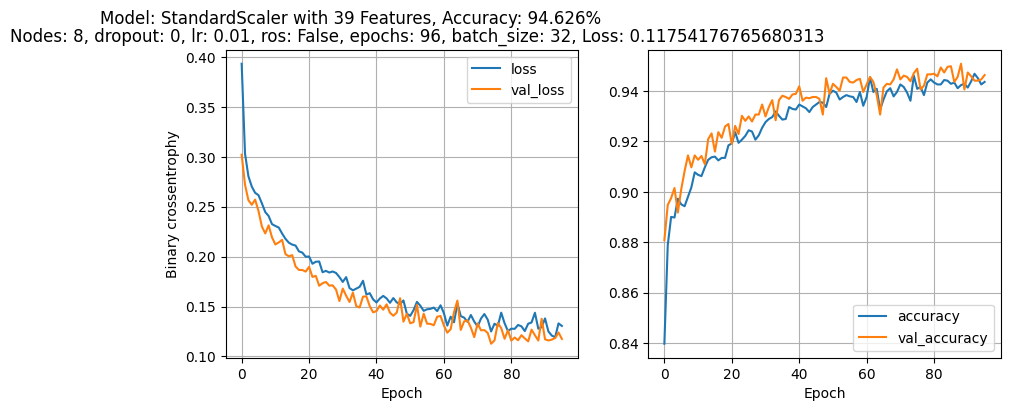

8 nodes, dropout 0, lr 0.01, ros False, batch size 64, epochs=96
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 320       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________

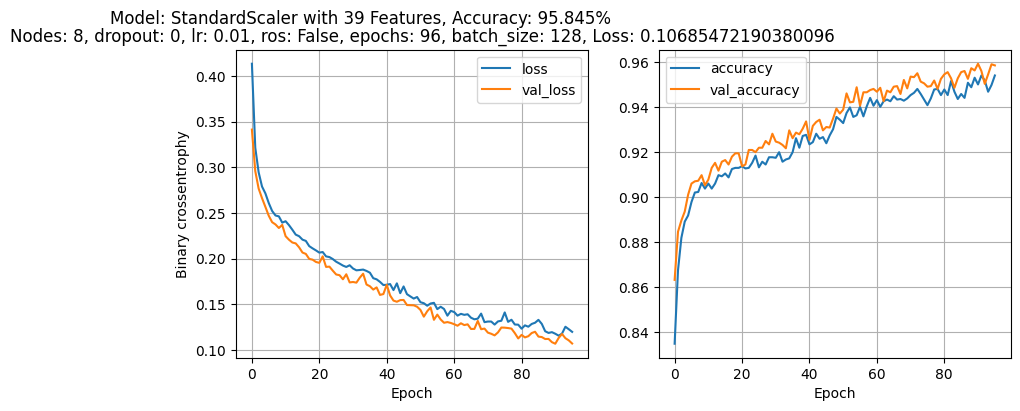

8 nodes, dropout 0, lr 0.005, ros False, batch size 32, epochs=96
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 8)                 320       
                                                                 
 dropout_6 (Dropout)         (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 8)                 72        
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
________________________________________________________

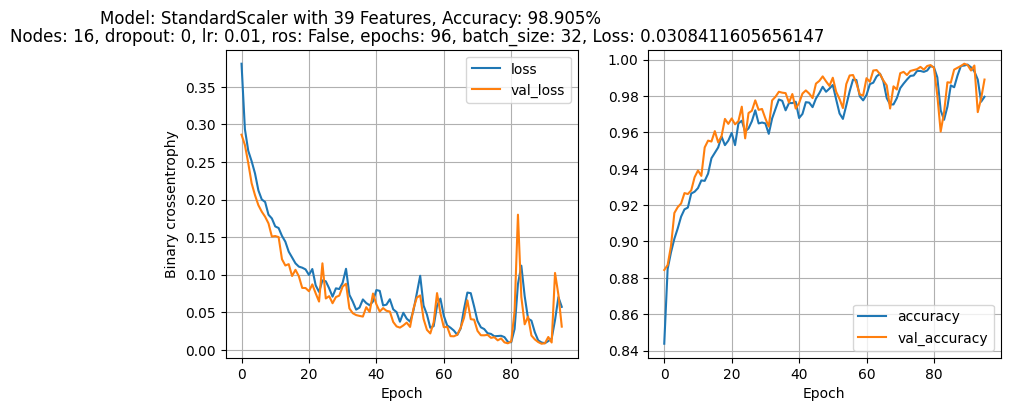

16 nodes, dropout 0, lr 0.01, ros False, batch size 64, epochs=96
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 16)                640       
                                                                 
 dropout_38 (Dropout)        (None, 16)                0         
                                                                 
 dense_58 (Dense)            (None, 16)                272       
                                                                 
 dropout_39 (Dropout)        (None, 16)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_______________________________________________________

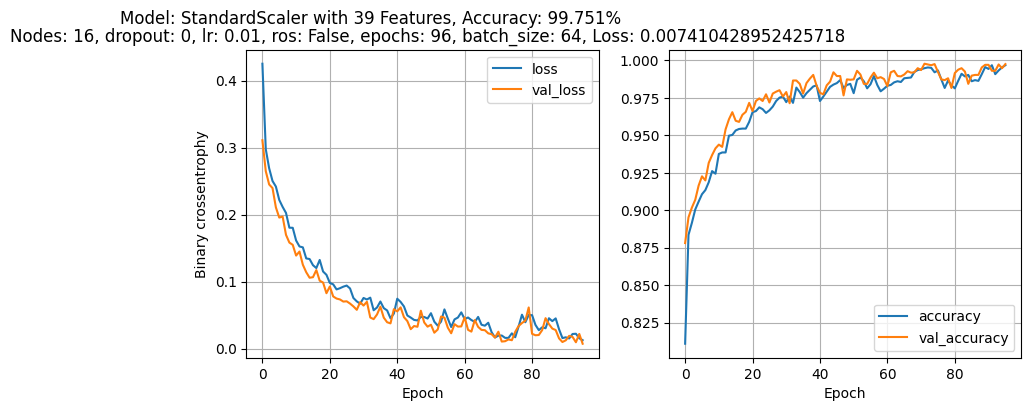

16 nodes, dropout 0, lr 0.01, ros False, batch size 128, epochs=96
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 16)                640       
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_61 (Dense)            (None, 16)                272       
                                                                 
 dropout_41 (Dropout)        (None, 16)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
______________________________________________________

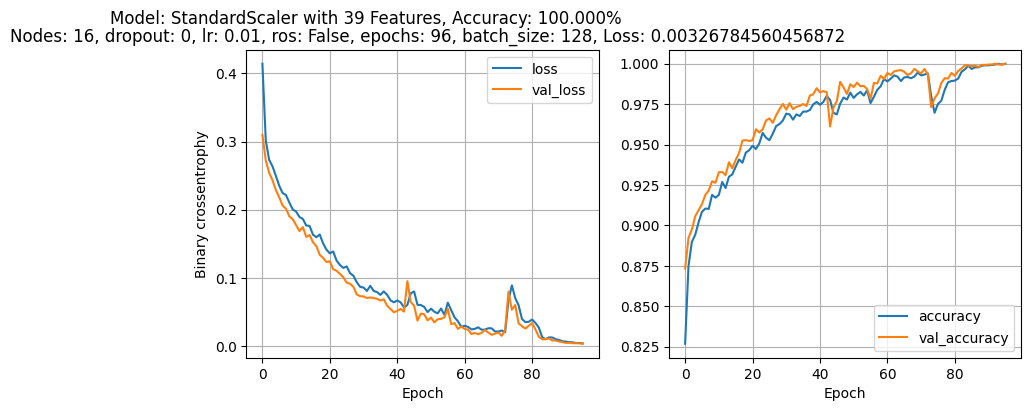

16 nodes, dropout 0, lr 0.005, ros False, batch size 32, epochs=96
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 16)                640       
                                                                 
 dropout_42 (Dropout)        (None, 16)                0         
                                                                 
 dense_64 (Dense)            (None, 16)                272       
                                                                 
 dropout_43 (Dropout)        (None, 16)                0         
                                                                 
 dense_65 (Dense)            (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
______________________________________________________

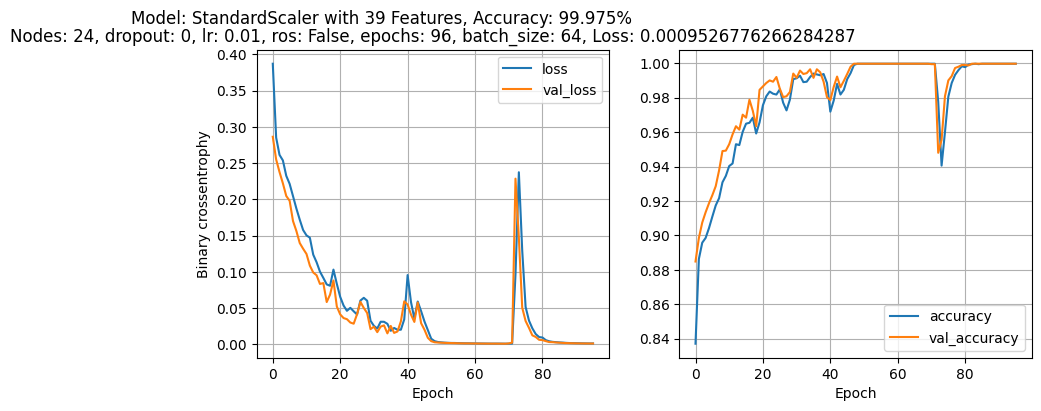

24 nodes, dropout 0, lr 0.01, ros False, batch size 128, epochs=96
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 24)                960       
                                                                 
 dropout_76 (Dropout)        (None, 24)                0         
                                                                 
 dense_115 (Dense)           (None, 24)                600       
                                                                 
 dropout_77 (Dropout)        (None, 24)                0         
                                                                 
 dense_116 (Dense)           (None, 1)                 25        
                                                                 
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
__________________________________________________

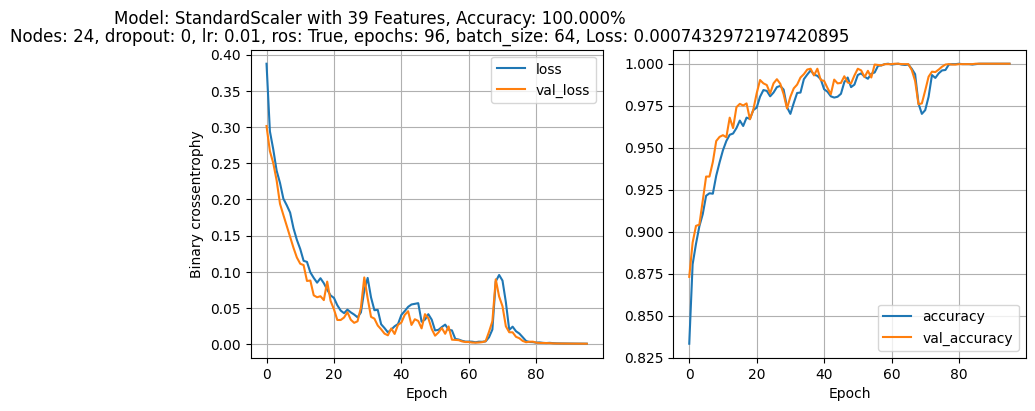

24 nodes, dropout 0, lr 0.01, ros True, batch size 128, epochs=96
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 24)                960       
                                                                 
 dropout_184 (Dropout)       (None, 24)                0         
                                                                 
 dense_277 (Dense)           (None, 24)                600       
                                                                 
 dropout_185 (Dropout)       (None, 24)                0         
                                                                 
 dense_278 (Dense)           (None, 1)                 25        
                                                                 
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
___________________________________________________

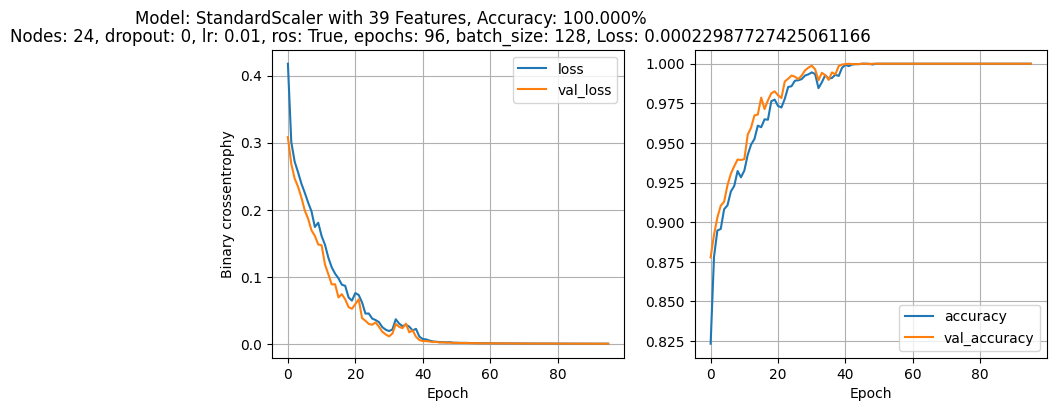

24 nodes, dropout 0, lr 0.005, ros True, batch size 32, epochs=96
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_279 (Dense)           (None, 24)                960       
                                                                 
 dropout_186 (Dropout)       (None, 24)                0         
                                                                 
 dense_280 (Dense)           (None, 24)                600       
                                                                 
 dropout_187 (Dropout)       (None, 24)                0         
                                                                 
 dense_281 (Dense)           (None, 1)                 25        
                                                                 
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
___________________________________________________

In [ ]:
# Set up and run model predictions
  # view the loss and accuracy of model
least_val_loss = float('inf')
least_loss_model = None

for oversample in oversamples:
  for node in [8, 16, 24]:
    for dropout_probability in [0, 0.2]:
      for learning_rate in [0.01, 0.005, 0.001]:
        for batch_size in [32, 64, 128]:
          print(f'{node} nodes, dropout {dropout_probability}, lr {learning_rate}, ros {oversample}, batch size {batch_size}, epochs={epochs}')
          nn, history = train_model(X_train, y_train, node, dropout_probability, learning_rate, oversample, batch_size, epochs)

          # calculate loss to find least loss (best model)
          loss_acc = nn.evaluate(X_valid, y_valid)
          a_score = loss_acc[1]  # model accuracy
          l_score = loss_acc[0]  # model loss  
          save_graph = False     
          # plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, oversample, batch_size, epochs, save_graph)
          
          if l_score < least_val_loss:
            least_val_loss = l_score
            least_loss_model = nn
            # save best model and graph
            # tf.keras.saving.save_model(nn, filepath, overwrite=True, save_format=None)
            # save_graph = True       
            plot_history(history, a_score, l_score, node, dropout_probability, learning_rate, oversample, batch_size, epochs, save_graph)